In [249]:
from glob import glob
import json
import re
import wikitextparser as wtp
import flair
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import networkx as nx
import seaborn as sns
import pandas as pd
import config
from collections import defaultdict
import pickle
sns.set()

In [9]:
flair_sentiment = flair.models.TextClassifier.load('en-sentiment')

2021-11-24 10:49:03,511 loading file C:\Users\lucas\.flair\models\sentiment-en-mix-distillbert_4.pt


In [369]:
char_sentiments = defaultdict(list)

seen_ids = {}
for fn in tqdm(glob('data/char_comments/*.njson')):
    char_name = os.path.basename(fn)[:-6].replace('_', ' ')

    comments = [json.loads(l) for l in open(fn, 'r', encoding='utf-8')]
    comments = sum(map(
        lambda c: [c] + c.get('replies', []),
        comments
    ), [])

    for comment in comments:
        text = comment.get('body', '')
        text = re.sub(r"\[.+?\]", "", text)
        text = re.sub(r"[\t\n\r]+", " ", text)
        s = flair.data.Sentence(text)
        flair_sentiment.predict(s)
        if len(s.labels) < 1:
            continue
        label = s.labels[0]
        sign = 1 if label.value == 'POSITIVE' else -1
        char_sentiments[char_name].append((comment['id'], sign*label.score))

with open('char_sentiments.pkl', 'wb') as f:
    pickle.dump(dict(char_sentiments), f)

  0%|          | 0/241 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [410]:
char_comments = {
    os.path.basename(fn)[:-6].replace('_', ' '): [json.loads(l) for l in open(fn, 'r', encoding='utf-8')]
    for fn in glob('data/char_comments/*.njson')
}

def standardize_comment(comment):
    return {
        'id': comment['id'],
        'body': comment['body'],
        'user': comment.get('user', comment.get('username')),
        'date': comment.get('date', comment.get('creationdate')),
        'rating': comment['rating'],
        'is_reply': comment.get('nreplies', 0) > 0
    }

# unpack replies from comments and resolve common keys
for char in char_comments:
    char_comments[char] = sum(map(
        lambda c: [standardize_comment(c)] + [standardize_comment(r) for r in c.get('replies', [])],
        char_comments[char]
    ), [])



char_sentiments = pickle.load(open('char_sentiments.pkl', 'rb'))
char_data = defaultdict(dict)
for char,comments in char_sentiments.items():
    for comment_id,sentiment in comments:
        comment = next(c for c in char_comments[char] if c['id'] == comment_id)
        char_data[char][comment_id] = {
            'date': ciso8601.parse_datetime_as_naive(comment['date']),
            'rating': comment['rating'],
            'bert_sentiment': sentiment,
            'is_reply': comment['is_reply']
        }

In [404]:
Gcc = nx.read_gexf(config.PATH_RES + 'Gcc_wow.gexf').to_undirected()
# load communities
communities = pickle.load(open(config.PATH_RES + 'Communities.json', 'rb'))

# get top chars in each community
degs = list(Gcc.degree())
com_names = []
for com in communities:
    com_sorted = sorted([(n, v) for n, v in degs if n in com], key=lambda x: x[1], reverse=True)
    top_names = [n for n, _ in com_sorted[:3]]
    com_name = ', '.join(top_names)
    com_names.append(com_name)
    
breakdown_lookup = {
    'faction': ('Faction', ['Horde', 'Alliance', 'Neutral']),
    'gender': ('Gender', ['Male', 'Female']),
    'status': ('Status', ['Alive', 'Deceased']),
    'community': ('Community', com_names)    
}

In [405]:
# read in character DataFrame
df = pd.read_csv(config.PATH_RES + 'df_chars.csv')
df = df[df.Name.apply(lambda n: n in char_sentiments)]
df = df[df.Name.apply(lambda n: n in Gcc)]
df.Faction = df.Faction.apply(lambda f: f if f in ['Horde', 'Alliance'] else 'Neutral')
df['Community'] = df.Name.apply(lambda n: com_names[next(i for i,C in enumerate(communities) if n in C)])
df.head()

,Name,Gender,Race,Faction,Status,Community
0,A'dal,Unknown,Naaru,Neutral,Alive,A'dal
2,Aegwynn,Female,Human,Neutral,Deceased,Aegwynn
3,Aessina,Female,Wisp,Neutral,Unknown,Aessina
4,Aethas Sunreaver,Male,Blood Elf,Horde,Alive,Aethas Sunreaver
5,Agamaggan,Male,Boar,Neutral,Deceased,Agamaggan


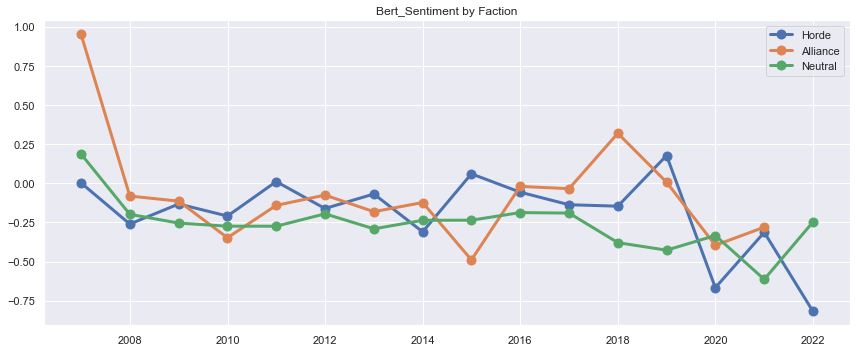

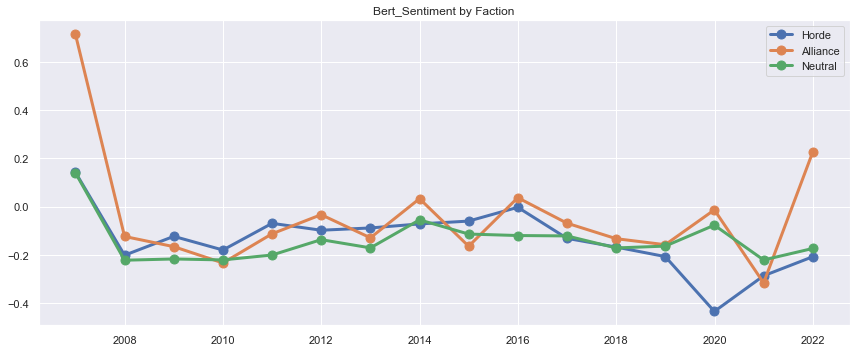

In [415]:
P = {
    'breakdown': 'faction', # ['faction', 'gender', 'status', 'community'],
    'metric': 'bert_sentiment', # ['bert_sentiment', 'vader_sentiment', 'rating', 'userRating'],
    'resample': 'Y', # ['M', 'Q', 'Y']
    'include_replies': True, # [True, False]
}


def plot_timeseries(params):
    plt.figure(figsize=(12,5))
    k,grps = breakdown_lookup[params['breakdown']]
    for val in grps:
        grp_chars = list(df[df[k] == val].Name)

        points = []
        for char in grp_chars:
            for comment_id,score in char_sentiments[char]:
                data = char_data[char][comment_id]
                if params['include_replies'] and not data['is_reply']:
                    continue
                points.append({
                    'date': data['date'],
                    'score': data[params['metric']]
                })
        d = pd.DataFrame(points)
        d = d[d.date > datetime(2006,6,1)]
        d = d[d.date < datetime(2021,11,1)]
        d = d.resample(params['resample'], on='date')
        x = list(d.indices)
        y = d.score.mean().dropna()
        plt.plot(x, y, 'o-', ms=9, linewidth=3, label=val)
    plt.title('%s by %s' % (params['metric'].title(), k))
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_timeseries(P)
plot_timeseries({**P, **{'include_replies': False}})